In [10]:
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.metrics import accuracy_score, cohen_kappa_score

import scyan

# Data Import

In [6]:
adata, marker_pop_matrix = scyan.data.load("aml")

# Maximizing Likelihood

In [14]:
model = scyan.Scyan(adata, marker_pop_matrix, lr=1e-3, hidden_size=16, n_hidden_layers=5, n_layers=5, ratio_threshold=5e-4, prior_std=0.2)

INFO:scyan.model:The provided adata is copied, prefer to use model.adata from now on.
INFO:scyan.metric:AnnotationMetrics callback setup with n_samples=100
INFO:scyan.model:Initialized Scyan model with N=104184 cells, P=14 populations and M=13 markers. No covariate provided.


In [15]:
esc = EarlyStopping(monitor="loss_epoch", min_delta=0.5, patience=4, check_on_train_epoch_end=True)
trainer = pl.Trainer(max_epochs=40, callbacks=[esc])
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 18.2 K
---------------------------------------
18.1 K    Trainable params
182       Non-trainable params
18.2 K    Total params
0.073     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/bio/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 37: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s, loss=-22.1, v_num=1, pi_rmse=0.102, accuracy_score=0.971]  


# Predictions and model evaluation

In [16]:
model.predict()
model.knn_predict()

print(f"\nModel accuracy: {accuracy_score(model.adata.obs.cell_type, model.adata.obs.scyan_knn_pop):.4f}")
print(f"Model Cohen's kappa: {cohen_kappa_score(model.adata.obs.cell_type, model.adata.obs.scyan_knn_pop):.4f}")


Model accuracy: 0.9826
Model Cohen's kappa: 0.9789


# Results

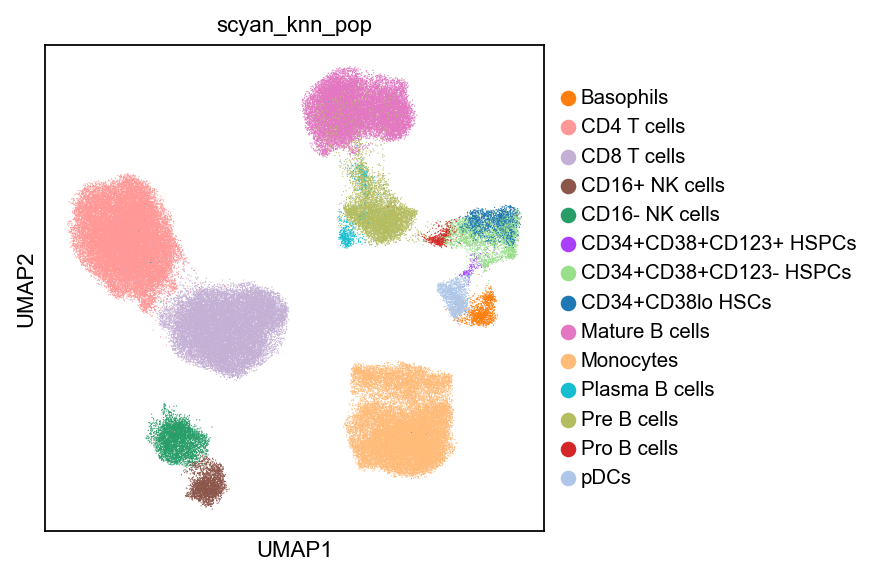

In [21]:
sc.pl.umap(model.adata, color="scyan_knn_pop", palette=adata.uns["palette"])

# Interpretability

Scyan's latent space has great mathematical properties which enhances data analysis
1. Each latent marker expression live in a comparable space in term of expressions (-1 is negative, 1 is positive)
2. Cell latent expression can be expressed by a cell population term and a cell specific term (e.g. auto-fluorescence)
3. Marker interdepence is contained inside the model so the probability that of a pop given a cell is a sum of log probabilities for each marker
4. We expect batch effect to be automatically removed
5. We can compute a UMAP on the cell latent space which enhance the cell population component
6. The model can be seen as a complex (i.e. ML model) unmixing and rescaling. Thus, maybe we could try to work on non-compensated data.

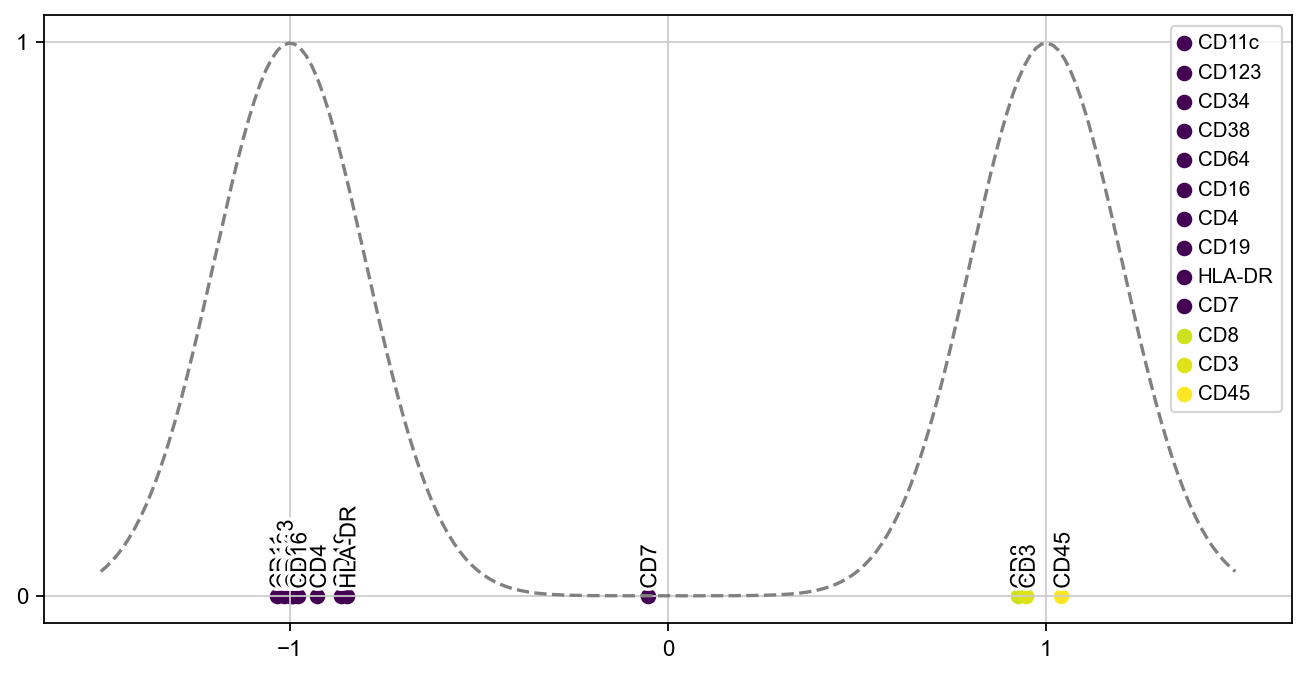

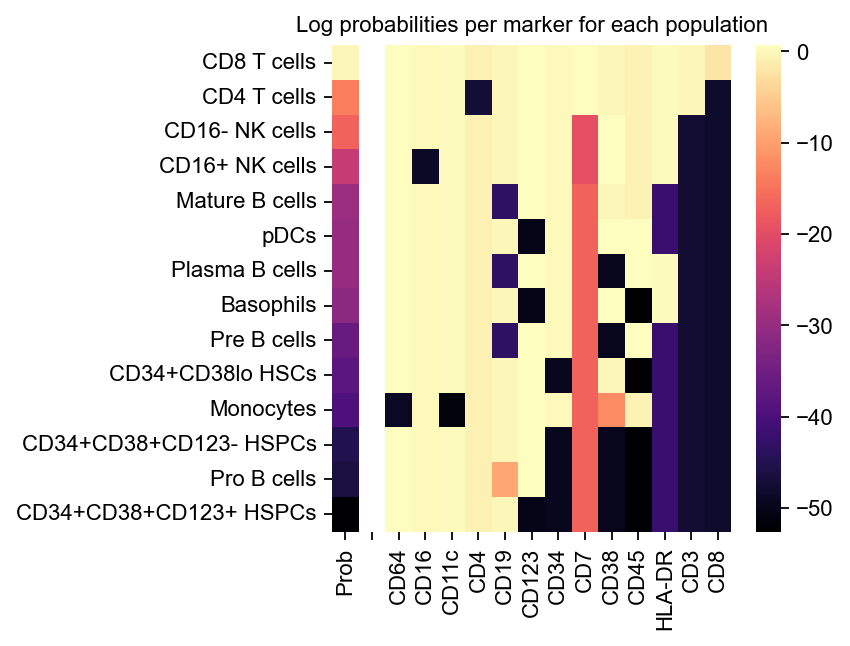

In [18]:
where = model.adata.obs.cell_type == "CD8 T cells"

scyan.plot.latent_expressions(model, where)
scyan.plot.probs_per_marker(model, where)

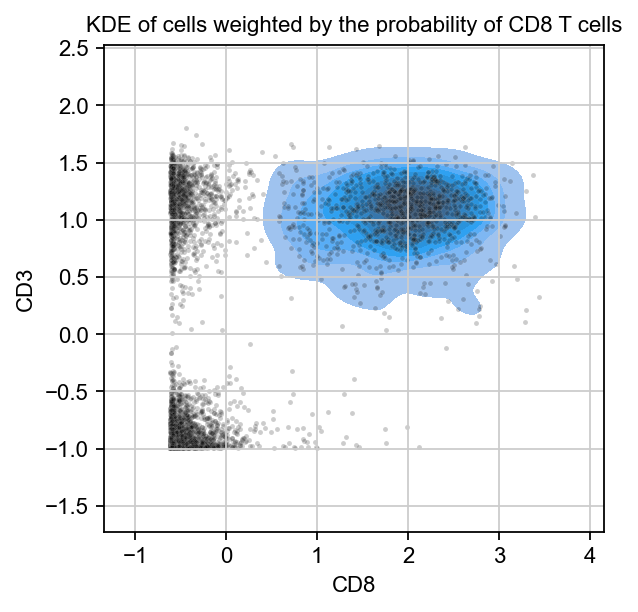

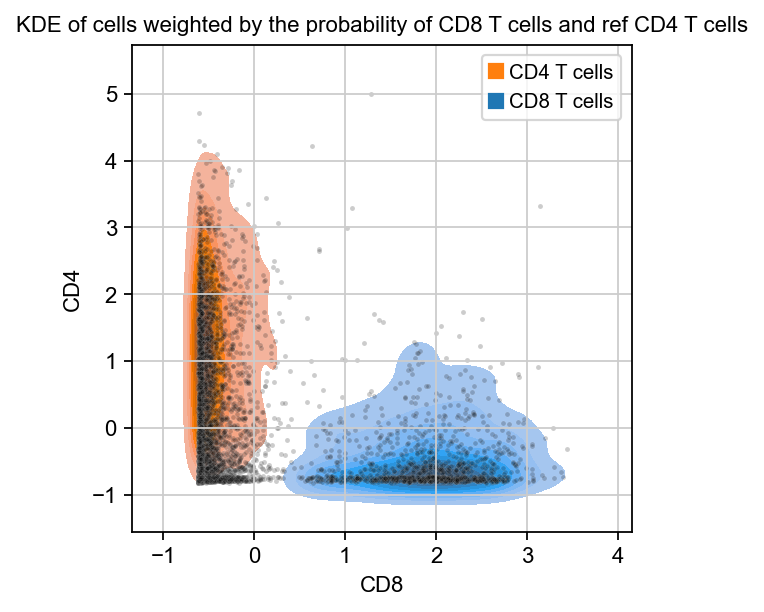

In [19]:
scyan.plot.pop_weighted_kde(model, "CD8 T cells") # show TCD8 vs the rest
scyan.plot.pop_weighted_kde(model, "CD8 T cells", ref="CD4 T cells") # show TCD8 vs TCD4

In [27]:
scyan.utils.process_umap_latent(model)

computing neighbors


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:47)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)


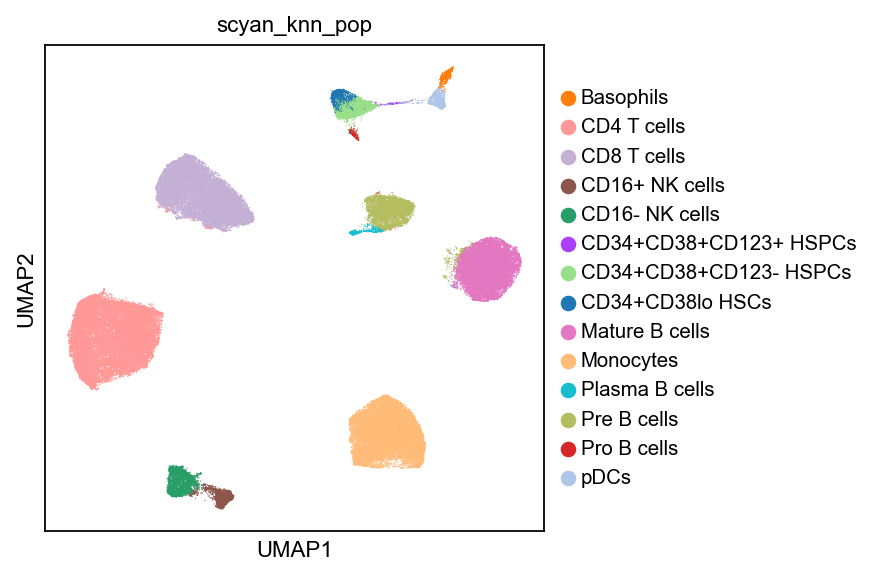

In [28]:
sc.pl.umap(model.adata, color="scyan_knn_pop", palette=adata.uns["palette"])